In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from os import path
from utils import plot_report

import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 20.0]
HDFStore=pd.HDFStore

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np

import config

In [2]:
# loading data parameters
num_coefficients=17

# training parameters
seed= config.seed

dr=0.2
lr2=1e-3
lr1=1e-4
lr=8e-4

num_epochs=1000
mini_batch_size=53

main_units=64
secondary_units=16
last_unit=8
lstm_units=64
num_classes=3

coefficients=17

print_sample=False

In [3]:
score = 'accuracy'

#this data has been previously processed by airflow
features = pd.read_csv("/data/elekin/data/results/handwriting/residues_{}_20220905.csv".format(coefficients)) #TODO automate
features = features.set_index(features.columns[0]).sort_index()
print("Loaded data from CSV")
features.head(10)

Loaded data from CSV


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
subject_id,,,,,,,,,,,,,,,,,,,,,
C01_1,0.0,139.606018,12.253823,74.690512,11.408070,53.418940,16.638002,35.400345,12.710705,31.302645,...,97.716552,114.776394,67.099198,47.384320,97.479009,149.785267,65.237339,76.287562,109.274009,603.564931
C01_2,0.0,177.624753,0.348489,98.753315,1.625123,65.488730,1.758768,53.448428,3.054443,38.169044,...,240.696817,219.388447,240.718694,280.058794,239.461137,208.220358,241.678183,365.281105,243.957987,572.808433
C02_1,0.0,165.150944,75.170220,60.824241,79.705065,1.594562,60.441501,32.667529,28.177814,39.863271,...,324.536773,317.472523,331.288106,376.283822,412.076268,377.760042,347.376473,355.744525,521.706493,978.147871
C02_2,0.0,173.554782,12.574759,98.943861,6.678424,54.118429,28.924473,67.616441,19.483121,21.156167,...,213.505816,194.441984,200.659434,236.751032,214.852886,193.616052,200.701936,312.150183,216.979357,582.719324
C03_1,0.0,166.058937,8.162449,90.288484,7.655655,63.642081,11.264714,44.946999,8.133135,39.269829,...,110.127463,141.380816,87.824980,51.011631,123.359510,208.409523,115.789266,43.064404,172.843460,777.956310
C03_2,0.0,180.359529,41.200908,86.240933,48.963521,45.659225,48.672469,23.795015,44.798236,12.303252,...,38.222312,29.984141,71.762030,26.147981,54.860823,81.810776,91.380828,136.944889,78.256296,626.050290
C04_1,0.0,161.031038,40.035450,75.208474,46.378921,37.164575,44.491143,13.810898,39.459239,1.067534,...,46.891543,67.959744,110.171362,56.936817,48.192530,135.669382,163.174494,76.527400,77.918980,665.297013
C04_2,0.0,110.061879,99.067986,40.937046,12.905609,44.446037,36.510156,14.889112,16.816469,25.185347,...,76.435121,85.696488,75.602701,75.550565,94.693787,88.904230,80.546806,104.947726,186.368011,326.125588
C05_1,0.0,148.984471,57.586698,53.911191,59.539912,8.614326,46.548562,16.633512,28.419032,26.986916,...,85.416671,70.591868,148.288139,146.469909,84.803629,166.218256,254.952333,117.337076,120.770225,680.851825


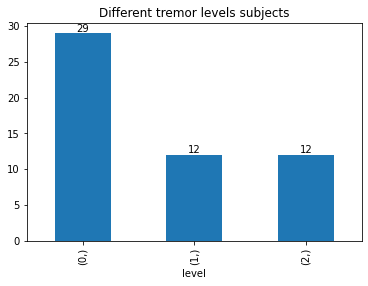

In [4]:
labels = pd.read_csv("/data/elekin/data/results/handwriting/level_20220903.csv", index_col=0).sort_index()
ax = labels.value_counts().plot.bar(title='Different tremor levels subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

In [5]:
np.array_equal(features.index.values, labels.index.values)

True

In [6]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(labels).astype(np.int16)
y.shape
#binary labels
#le = LabelEncoder().fit(labels.values.ravel())
#y = le.fit_transform(labels.values.ravel()).astype(np.int16)
#y

(53, 3)

In [7]:
X=features.values.astype(np.float64)
X.shape

(53, 4096)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=38)

In [9]:
x_train.shape, x_test.shape

((35, 4096), (18, 4096))

In [10]:
num_features = x_train.shape[1]

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

if print_sample:
    for feat, targ in test_dataset.take(10):
        print ('Features test: {}, Target: {}'.format(feat, targ))

    for feat, targ in test_dataset.take(10):
        print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))

1 train batches and 1 test batches of 53 mini batch size and 0 steps per epoch


## FCNN ARCHITECTURE ANALISYS

Some training helpers functions

In [12]:
# #Early stop configuration
earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=1e-3,
  patience=200)

training_earlystop_callback = EarlyStopping(
  monitor='accuracy', min_delta=1e-4,
  patience=200)

def get_callbacks(name):
    return [
        #tfdocs.modeling.EpochDots(),
        earlystop_callback,
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-5),
        #tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, train_dataset, test_dataset, name, optimizer=None, max_epochs=1000):
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(name),
                        verbose=1, shuffle=False)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [13]:
size_histories = {}

In [14]:
tiny = tf.keras.models.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)])

size_histories['fcnn/tiny'] = compile_and_fit(tiny, train_dataset, 
                                              test_dataset,
                                              "fcnn/tiny", 
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 262,403
Trainable params: 262,403
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 1s 652ms/step - loss: 8.4087 - accuracy: 0.4286 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 2/1000
1/1 [==============================] - 0s 7ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 3/1000
1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 4/1000
1/1 [======

1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 55/1000
1/1 [==============================] - 0s 7ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 56/1000
1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 57/1000
1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 58/1000
1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 59/1000
1/1 [==============================] - 0s 7ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 60/1000
1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 61/1000
1/1 [========

1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 113/1000
1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 114/1000
1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 115/1000
1/1 [==============================] - 0s 7ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 116/1000
1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 117/1000
1/1 [==============================] - 0s 7ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 118/1000
1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 119/1000
1/1 [=

Epoch 170/1000
1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 171/1000
1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 172/1000
1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 173/1000
1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 174/1000
1/1 [==============================] - 0s 7ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 175/1000
1/1 [==============================] - 0s 6ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 176/1000
1/1 [==============================] - 0s 7ms/step - loss: 8.2893 - accuracy: 0.4857 - val_loss: 5.3727 - val_accuracy: 0.6667
Epoch 

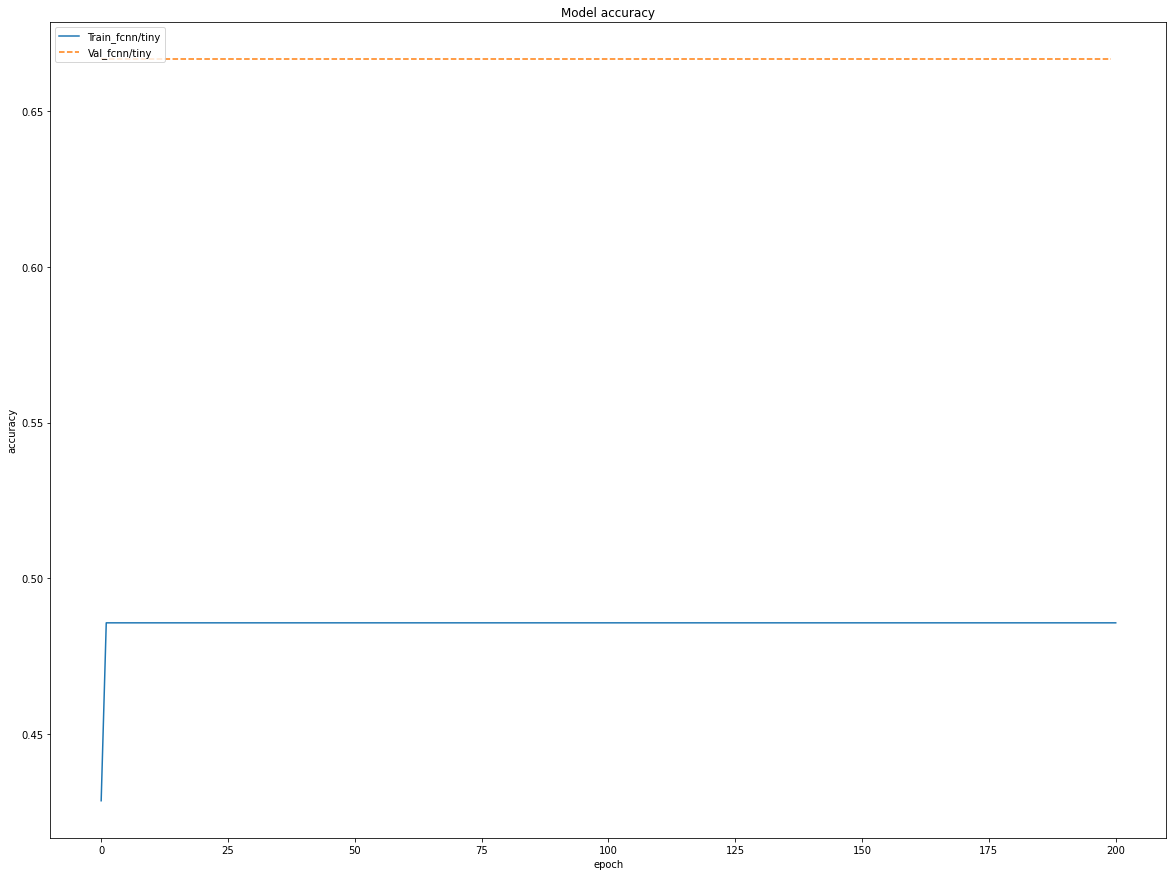

In [15]:
mpl.rcParams['figure.figsize'] = [20.0, 15.0]
plot_report(size_histories, metric='accuracy')

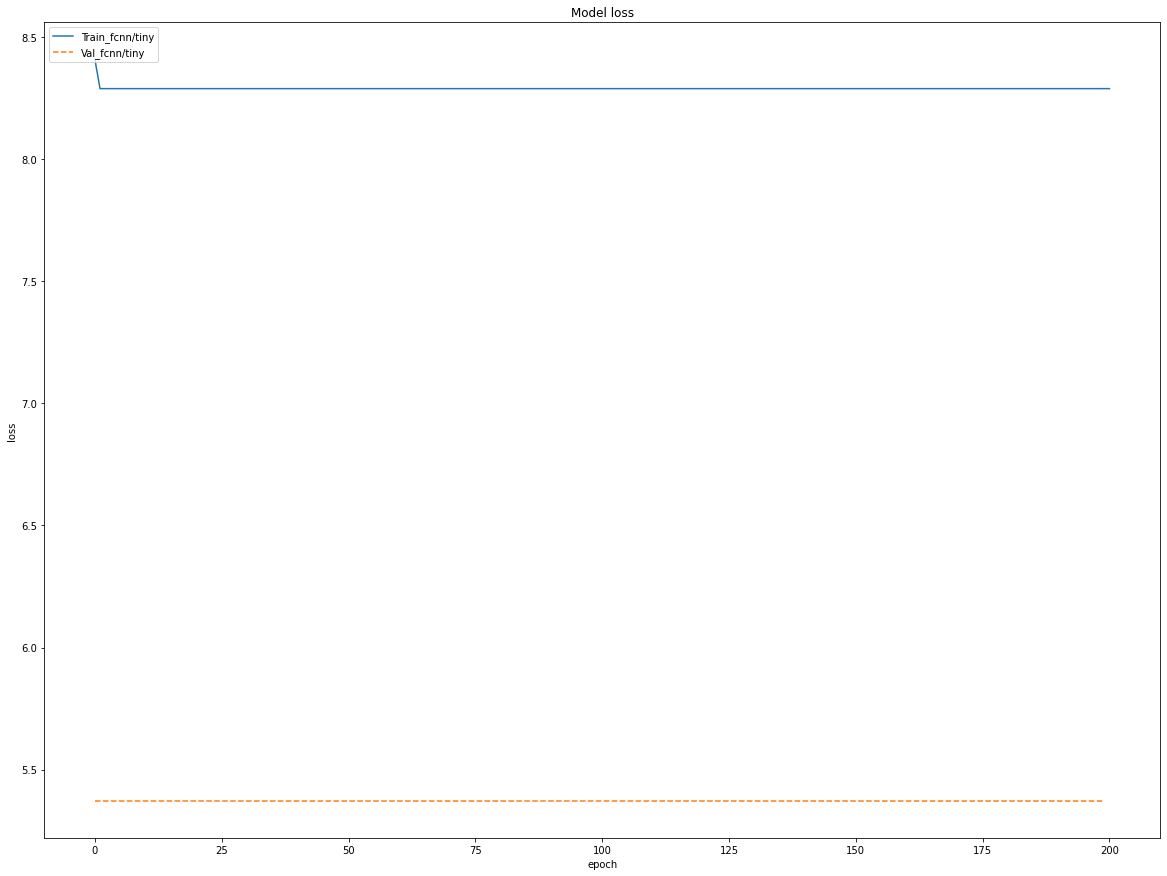

In [16]:
plot_report(size_histories, 'loss')

In [17]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/small'] = compile_and_fit(small_model, train_dataset, 
                                              test_dataset,'fcnn/small',
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/small'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/small'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 263,299
Trainable params: 263,299
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 0s 291ms/step - loss: 3.0724 - accuracy: 0.4000 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 2/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.0536 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 3/1000
1/1 [==============

1/1 [==============================] - 0s 11ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 54/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 55/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 56/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 57/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 58/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 59/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 60/1000
1/1 [=======

1/1 [==============================] - 0s 8ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 112/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 113/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 114/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 115/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 116/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 117/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 118/1000
1/1 [=

Epoch 169/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 170/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 171/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 172/1000
1/1 [==============================] - 0s 6ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 173/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 174/1000
1/1 [==============================] - 0s 6ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 175/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.0986 - accuracy: 0.4857 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 

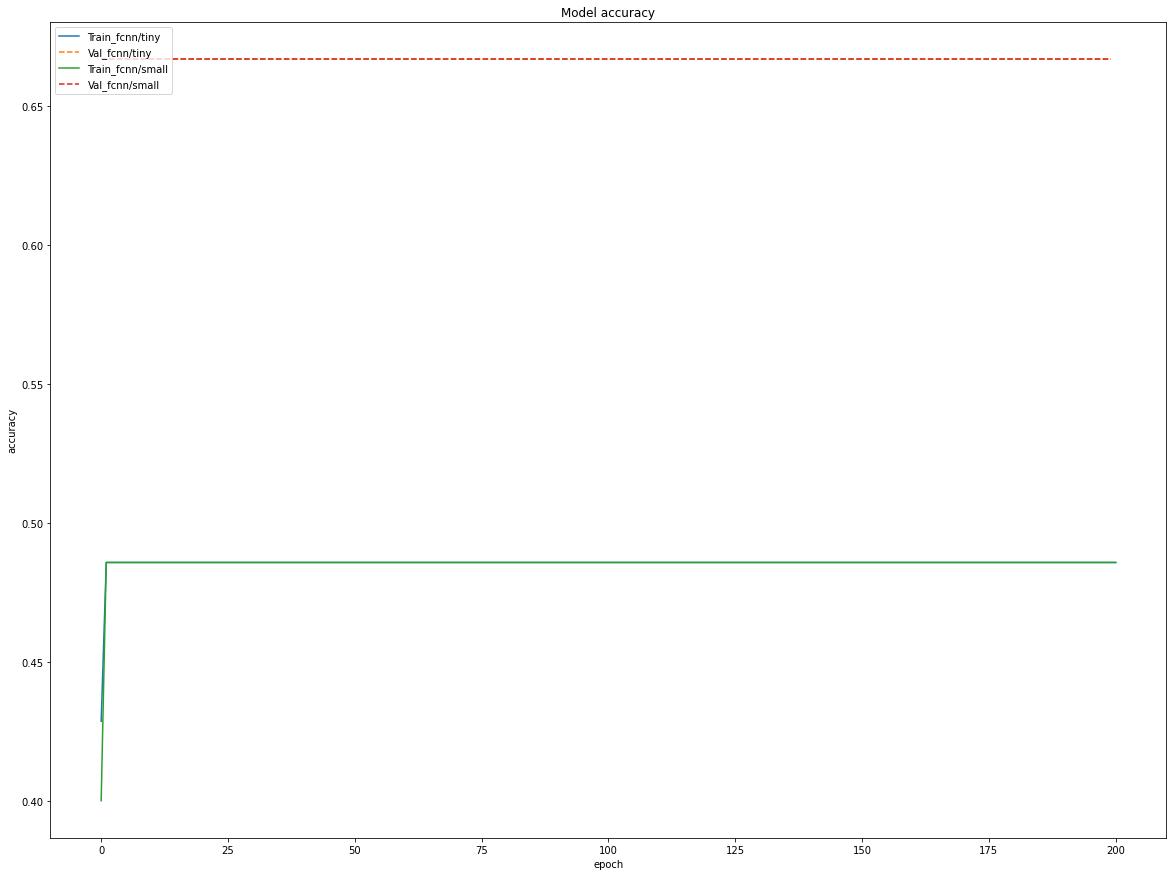

In [18]:
plot_report(size_histories)

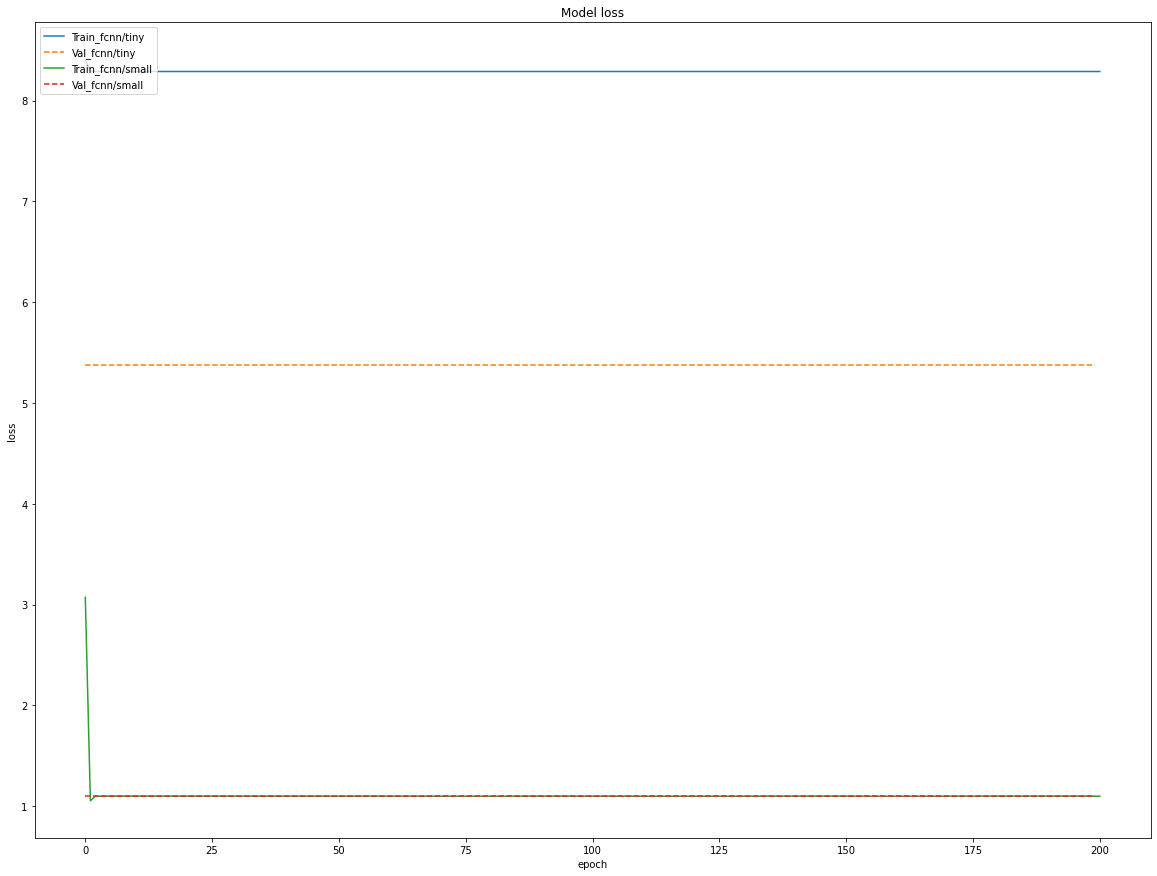

In [19]:
plot_report(size_histories, 'loss')

In [20]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),  
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/large'] = compile_and_fit(large_model, train_dataset, 
                                              test_dataset, "fcnn/large",
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer=get_optimizer(), 
                                              max_epochs=num_epochs)

print("Evaluation")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/large'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 3)                 27        
                                                                 
Total params: 267,571
Trainable params: 267,571
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] 

1/1 [==============================] - 0s 9ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 52/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 53/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 54/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 55/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 56/1000
1/1 [==============================] - 0s 9ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 57/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 58/1000
1/1 [========

1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 110/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 111/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 112/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 113/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 114/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 115/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 116/1000
1/1 [=

Epoch 167/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 168/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 169/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 170/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 171/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 172/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 173/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 

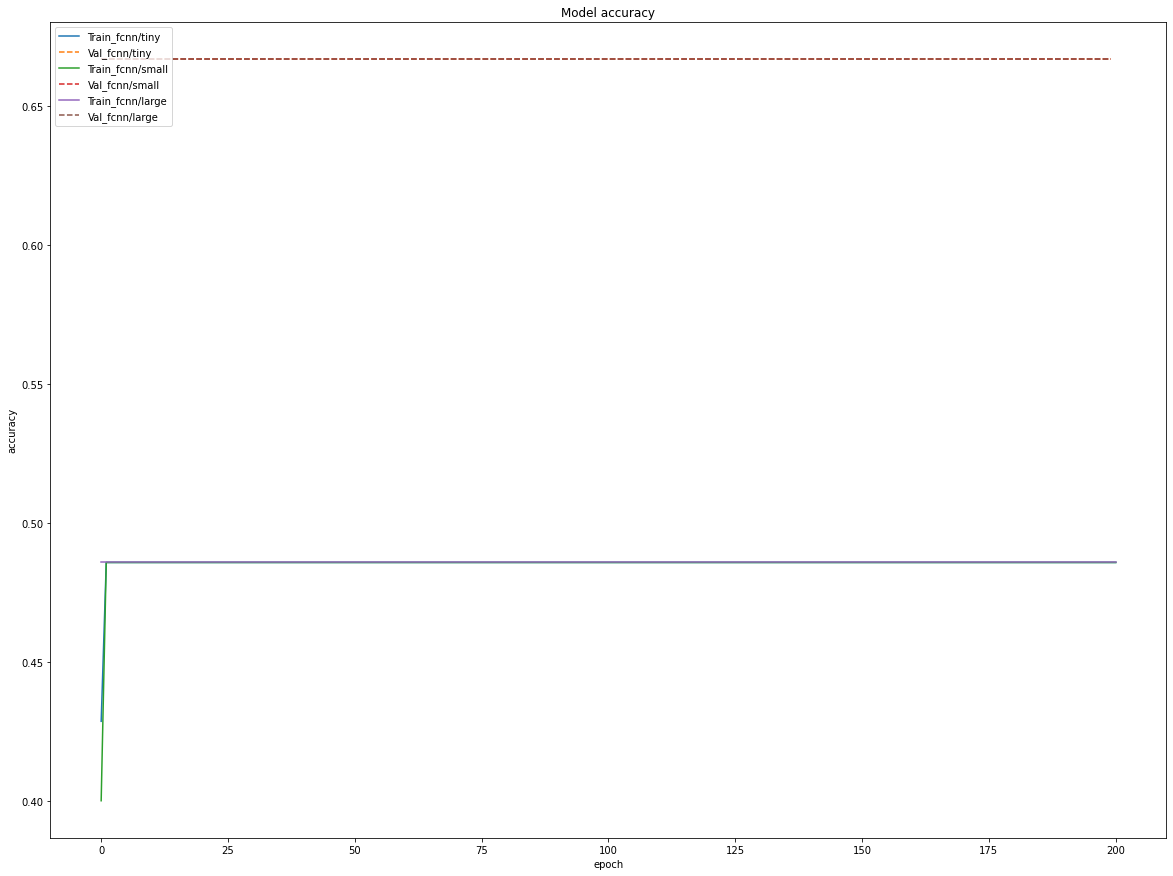

In [21]:
plot_report(size_histories)

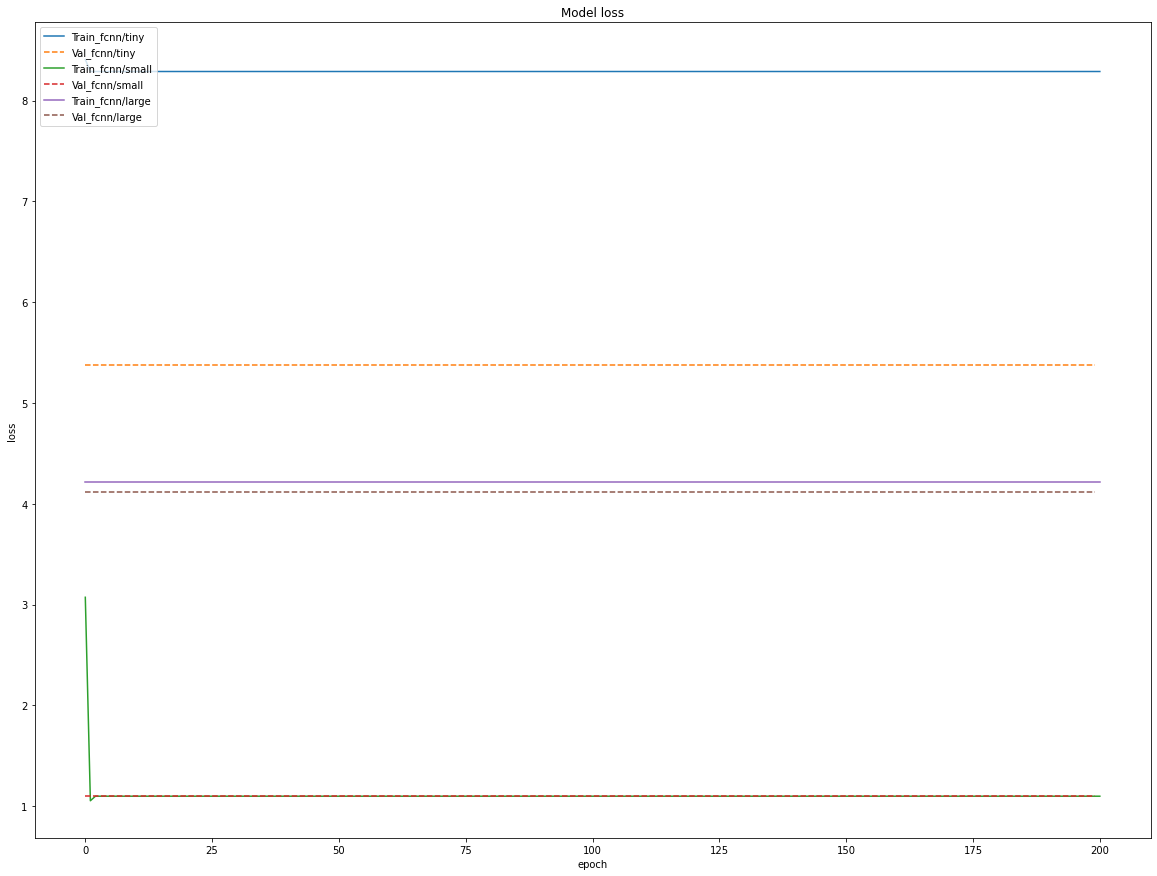

In [22]:
plot_report(size_histories, 'loss')

### Dropout

Although we got an accuracy of 0.75 looking at loss function chart is pretty obvious: There is overfiting. Now we have an overfitted NN let's make some adjustments to improve generalization capacity startin from dropout techniques.  

In [23]:
tiny_dropout = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/tiny/dropout'] = compile_and_fit(tiny_dropout, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/tiny/dropout", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATIO######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny/dropout'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny/dropout'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                262208    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 3)                 2

1/1 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 52/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 53/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 54/1000
1/1 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 55/1000
1/1 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 56/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 57/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 58/1000
1/1 [==============================] - 0s 8ms/step - lo

1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 112/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 113/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 114/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 115/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 116/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 117/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 118/1000
1/1 [==============================] - 0s 7ms/st

1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 172/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 173/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 174/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 175/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 176/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 177/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 178/1000
1/1 [==============================] - 0s 7ms/st

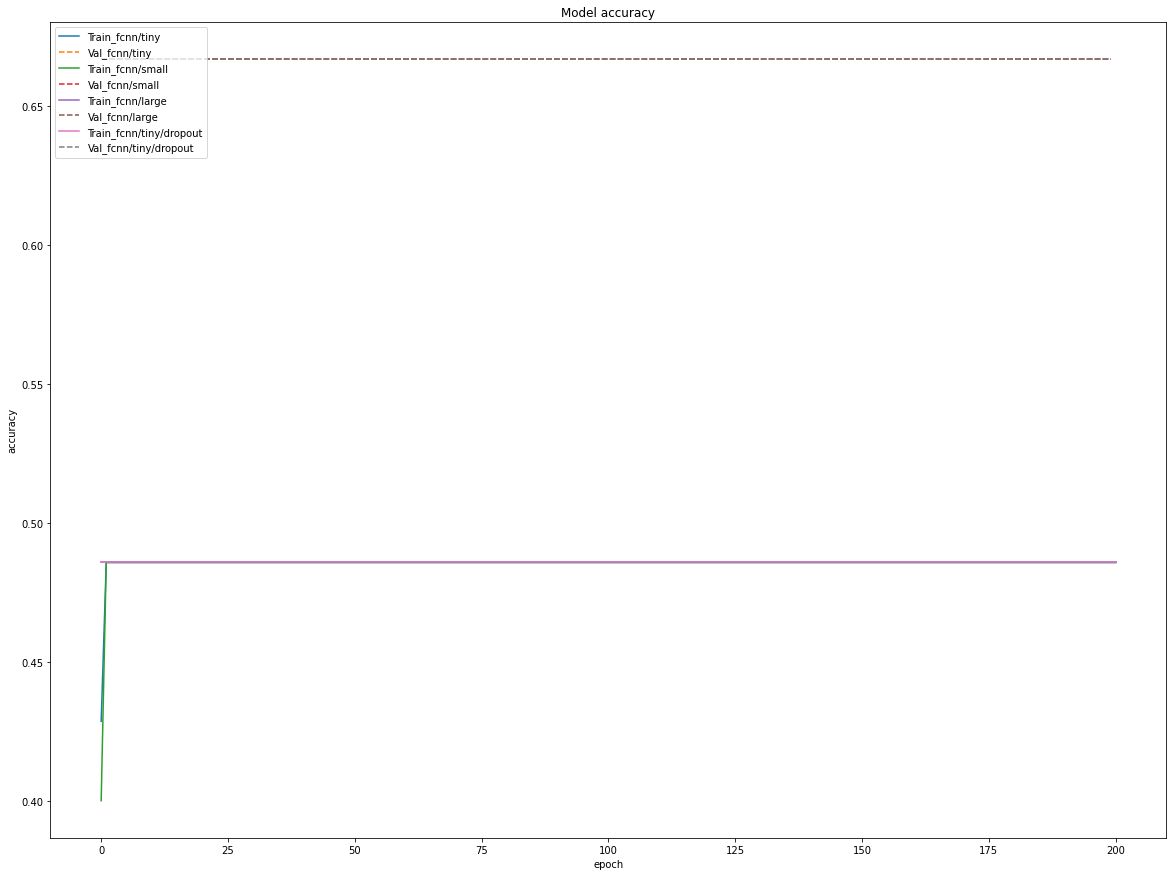

In [24]:
plot_report(size_histories)

Validation accuracy keeps improving more epoch with a total improvement from 0.75 to 0.81. Furthemore, the gap between training loss function and test loss function has been reduced.

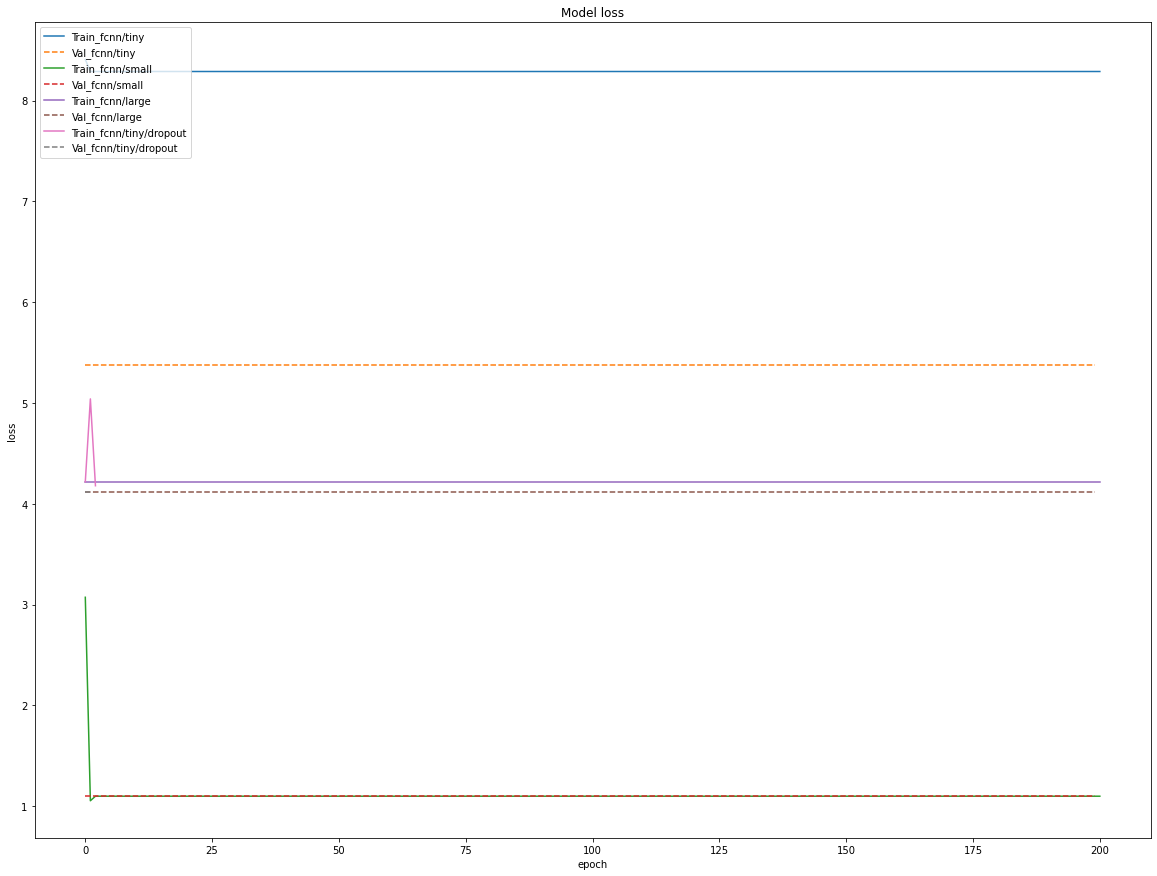

In [25]:
plot_report(size_histories, metric='loss')

### Kernel regularizer

In [26]:
# shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
# shutil.copytree(logdir/'fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['large'] = size_histories['fcnn/large']
regularizer_histories['dropout'] = size_histories['fcnn/tiny/dropout']

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [27]:
l2_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
regularizer_histories['l2'] = compile_and_fit(l2_model, train_dataset, 
                                              test_dataset, 
                                              optimizer=tf.keras.optimizers.Adam(lr),
                                              name="regularizers/l2")
# Evaluate the model on the test data using `evaluate`
print("\n#######################EVALUATIO######################")
print('test acc:', max(regularizer_histories['l2'].history["val_accuracy"]))
print('train acc:', max(regularizer_histories['l2'].history["accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 3)                 27        
                                                                 
Total params: 267,571
Trainable params: 267,571
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] 

1/1 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 53/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 54/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 55/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 56/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 57/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 58/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 59/1000
1/1 [==============================] - 0s 7ms/step - lo

Epoch 113/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 114/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 115/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 116/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 117/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 118/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 119/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 120/1000
1/1 [============================

1/1 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 174/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 175/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 176/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 177/1000
1/1 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 178/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 179/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 180/1000
1/1 [==============================] - 0s 9ms/st

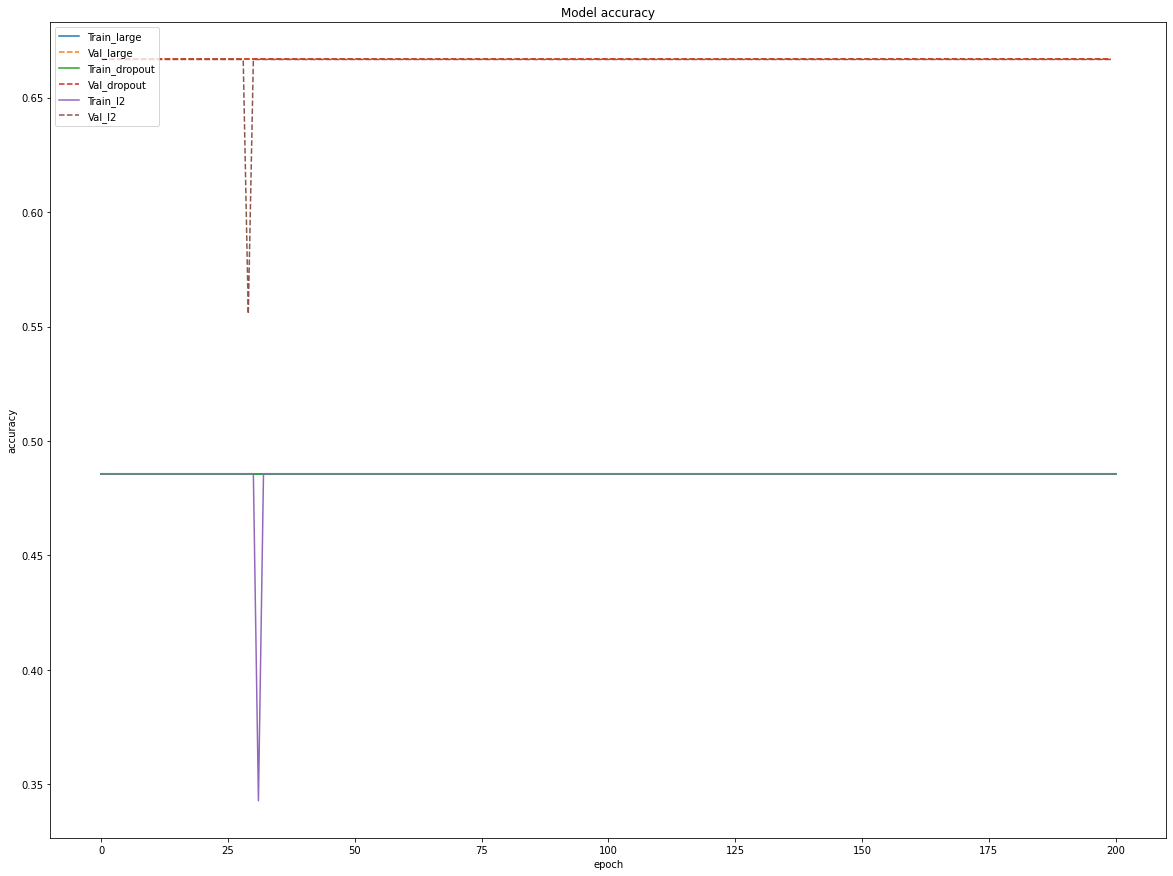

In [28]:
plot_report(regularizer_histories, 'accuracy')

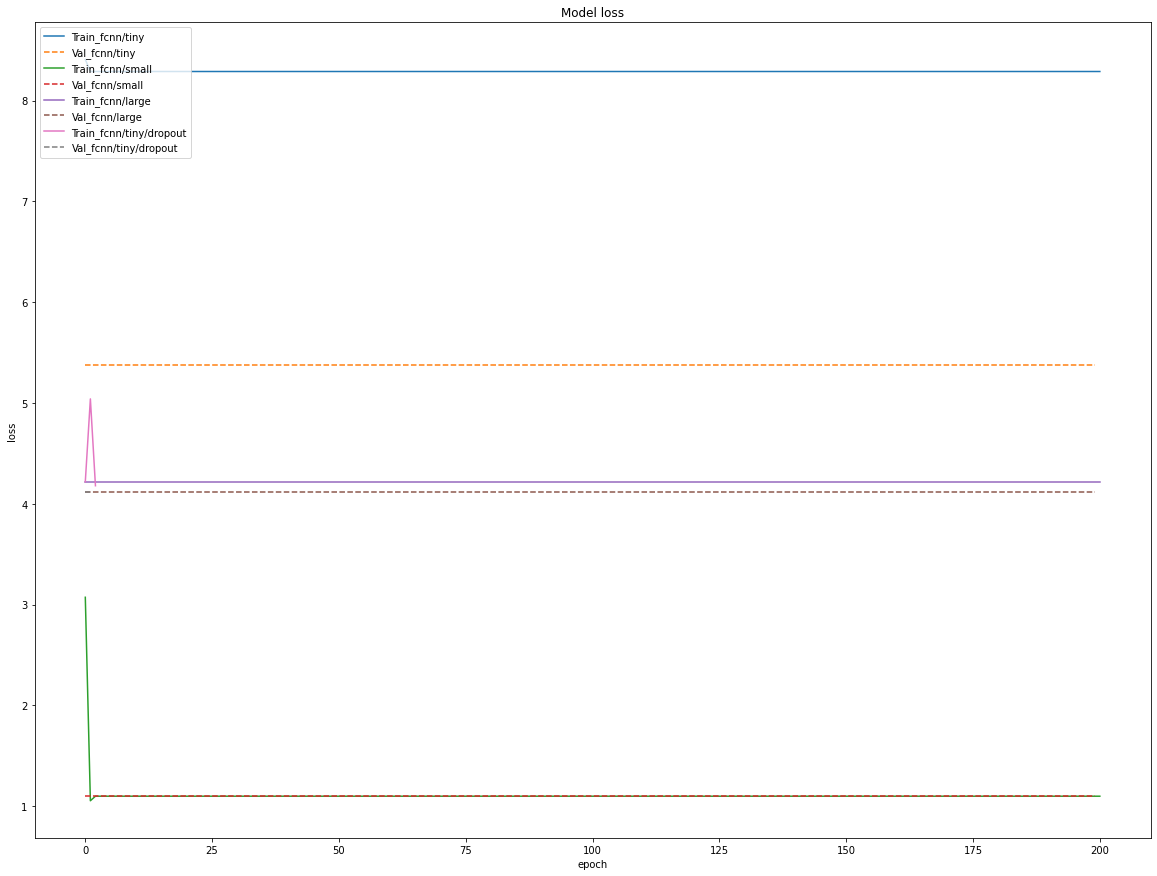

In [29]:
plot_report(size_histories, 'loss')

Now let's see what happens combining both techniques

In [30]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
combined_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    tf.keras.layers.Dropout(dr),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])

tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
regularizer_histories['combined'] = compile_and_fit(combined_model, train_dataset, test_dataset, "regularizers/combined",
                                                   optimizer=get_optimizer())

# Evaluate the model on the test data using `evaluate`
print()
print('test acc:', max(regularizer_histories['combined'].history["val_accuracy"]))
print('train acc:', max(regularizer_histories['combined'].history["accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 3)                 27        
                                                                 
Total params: 267,571
Trainable params: 267,571
Non-trai

1/1 [==============================] - 0s 7ms/step - loss: 4.6977 - accuracy: 0.4571 - val_loss: 4.5874 - val_accuracy: 0.6667
Epoch 51/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2562 - accuracy: 0.4857 - val_loss: 4.5865 - val_accuracy: 0.6667
Epoch 52/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.6845 - accuracy: 0.4857 - val_loss: 4.5857 - val_accuracy: 0.6667
Epoch 53/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.6952 - accuracy: 0.4571 - val_loss: 4.5848 - val_accuracy: 0.6667
Epoch 54/1000
1/1 [==============================] - 0s 7ms/step - loss: 5.1351 - accuracy: 0.4857 - val_loss: 4.5840 - val_accuracy: 0.6667
Epoch 55/1000
1/1 [==============================] - 0s 7ms/step - loss: 5.1226 - accuracy: 0.4571 - val_loss: 4.5831 - val_accuracy: 0.6667
Epoch 56/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.6811 - accuracy: 0.4857 - val_loss: 4.5823 - val_accuracy: 0.6667
Epoch 57/1000
1/1 [========

1/1 [==============================] - 0s 7ms/step - loss: 4.6407 - accuracy: 0.4857 - val_loss: 4.5420 - val_accuracy: 0.6667
Epoch 109/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.6400 - accuracy: 0.4857 - val_loss: 4.5414 - val_accuracy: 0.6667
Epoch 110/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.6393 - accuracy: 0.4857 - val_loss: 4.5407 - val_accuracy: 0.6667
Epoch 111/1000
1/1 [==============================] - 0s 8ms/step - loss: 5.1954 - accuracy: 0.4857 - val_loss: 4.5400 - val_accuracy: 0.6667
Epoch 112/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.6379 - accuracy: 0.4857 - val_loss: 4.5393 - val_accuracy: 0.6667
Epoch 113/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.6372 - accuracy: 0.4857 - val_loss: 4.5386 - val_accuracy: 0.6667
Epoch 114/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.6365 - accuracy: 0.4857 - val_loss: 4.5379 - val_accuracy: 0.6667
Epoch 115/1000
1/1 [=

Epoch 166/1000
1/1 [==============================] - 0s 9ms/step - loss: 4.6048 - accuracy: 0.4857 - val_loss: 4.5064 - val_accuracy: 0.6667
Epoch 167/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.6043 - accuracy: 0.4857 - val_loss: 4.5059 - val_accuracy: 0.6667
Epoch 168/1000
1/1 [==============================] - 0s 9ms/step - loss: 4.6051 - accuracy: 0.4857 - val_loss: 4.5054 - val_accuracy: 0.6667
Epoch 169/1000
1/1 [==============================] - 0s 9ms/step - loss: 4.6033 - accuracy: 0.4857 - val_loss: 4.5048 - val_accuracy: 0.6667
Epoch 170/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.1737 - accuracy: 0.4857 - val_loss: 4.5043 - val_accuracy: 0.6667
Epoch 171/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.6023 - accuracy: 0.4857 - val_loss: 4.5038 - val_accuracy: 0.6667
Epoch 172/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.6018 - accuracy: 0.4857 - val_loss: 4.5033 - val_accuracy: 0.6667
Epoch 

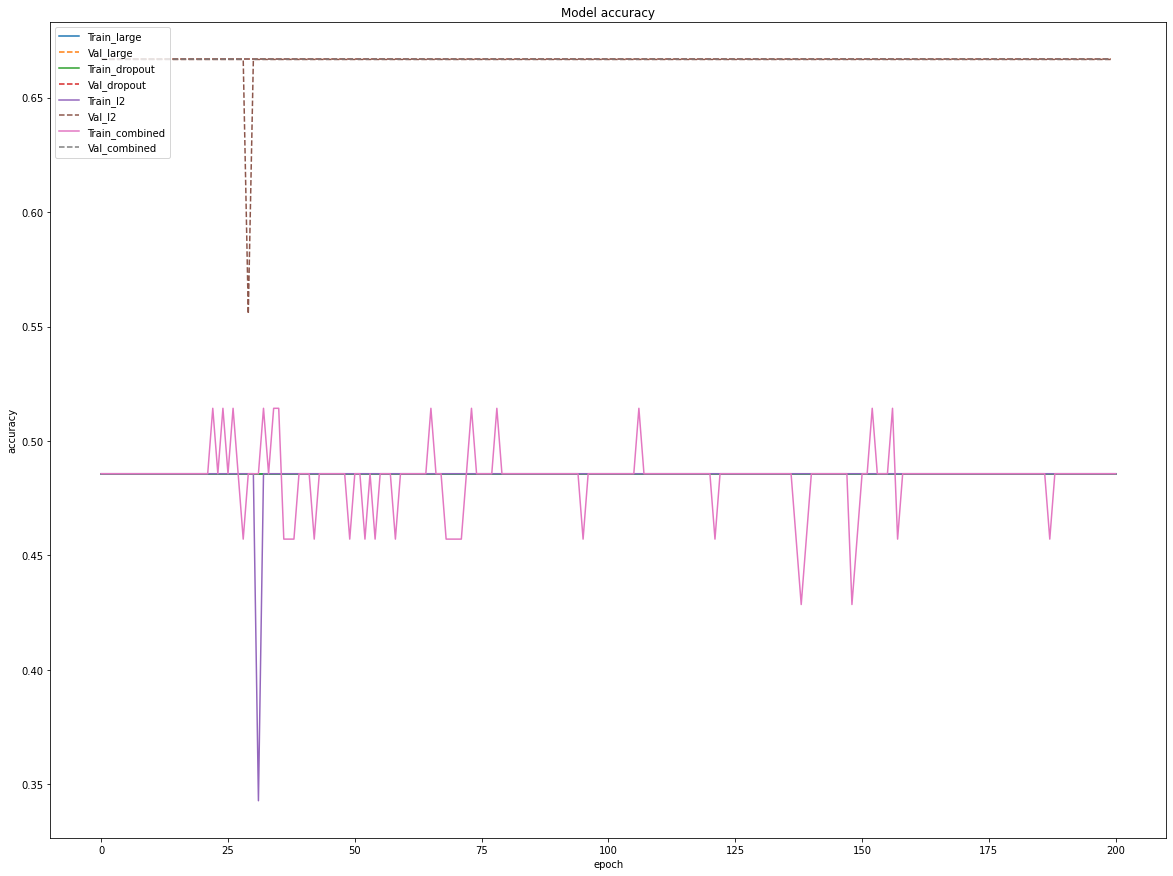

In [31]:
plot_report(regularizer_histories, 'accuracy')

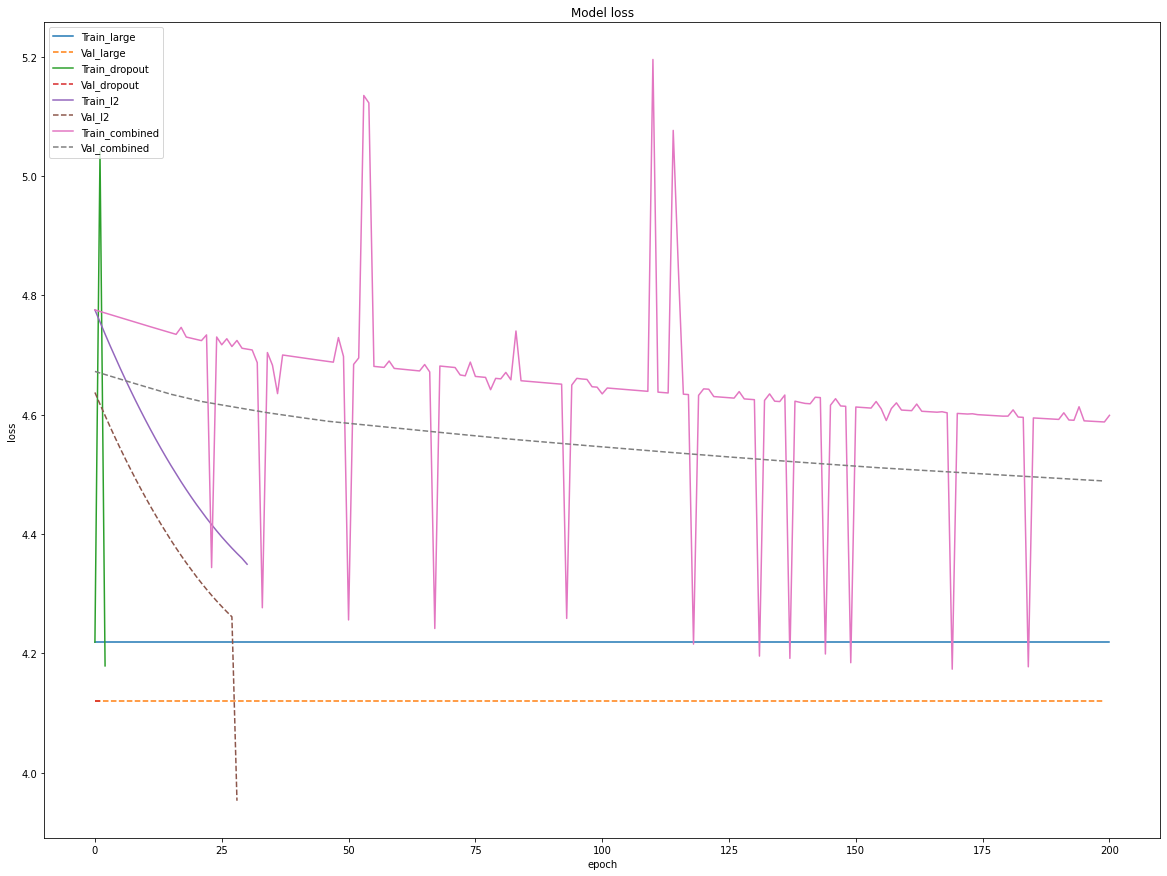

In [32]:
plot_report(regularizer_histories, 'loss')

## Batch Normalization

Batch normalization (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling. It was proposed by Sergey Ioffe and Christian Szegedy in 2015.

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Tensorflow implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)


In [33]:
batch_histories = {}
batch_histories['large'] = size_histories['fcnn/large']
batch_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [34]:
small_batch = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
batch_histories['fcnn/small/batch'] = compile_and_fit(small_batch, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/small/batch", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(batch_histories['fcnn/small/batch'].history["accuracy"]))
print('test acc:', max(batch_histories['fcnn/small/batch'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                262208    
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 batch_normalization_2 (Batc  (None, 16)               6

Epoch 45/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.7659 - accuracy: 0.7143 - val_loss: 1.4064 - val_accuracy: 0.6667
Epoch 46/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.7468 - accuracy: 0.7429 - val_loss: 1.4173 - val_accuracy: 0.6667
Epoch 47/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.7731 - accuracy: 0.6857 - val_loss: 1.4265 - val_accuracy: 0.7222
Epoch 48/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.7385 - accuracy: 0.7714 - val_loss: 1.4339 - val_accuracy: 0.7222
Epoch 49/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.7132 - accuracy: 0.7714 - val_loss: 1.4412 - val_accuracy: 0.7222
Epoch 50/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.7524 - accuracy: 0.7143 - val_loss: 1.4473 - val_accuracy: 0.7222
Epoch 51/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.7475 - accuracy: 0.7143 - val_loss: 1.4516 - val_accuracy: 0.7222
Epoch 52/1000

1/1 [==============================] - 0s 9ms/step - loss: 0.5839 - accuracy: 0.7429 - val_loss: 1.8166 - val_accuracy: 0.6667
Epoch 104/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6437 - accuracy: 0.7429 - val_loss: 1.8113 - val_accuracy: 0.7222
Epoch 105/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6404 - accuracy: 0.8000 - val_loss: 1.7973 - val_accuracy: 0.7222
Epoch 106/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.5952 - accuracy: 0.7143 - val_loss: 1.7837 - val_accuracy: 0.7222
Epoch 107/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6161 - accuracy: 0.8000 - val_loss: 1.7697 - val_accuracy: 0.6667
Epoch 108/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6041 - accuracy: 0.7714 - val_loss: 1.7570 - val_accuracy: 0.6667
Epoch 109/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6408 - accuracy: 0.7143 - val_loss: 1.7479 - val_accuracy: 0.6667
Epoch 110/1000
1/1 [=

Epoch 161/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.5272 - accuracy: 0.8000 - val_loss: 1.8645 - val_accuracy: 0.3889
Epoch 162/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.5094 - accuracy: 0.8857 - val_loss: 1.8301 - val_accuracy: 0.3889
Epoch 163/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.5104 - accuracy: 0.8571 - val_loss: 1.8252 - val_accuracy: 0.3889
Epoch 164/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.5223 - accuracy: 0.7714 - val_loss: 1.8345 - val_accuracy: 0.3889
Epoch 165/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.4968 - accuracy: 0.8286 - val_loss: 1.8581 - val_accuracy: 0.3889
Epoch 166/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.5353 - accuracy: 0.8000 - val_loss: 1.8515 - val_accuracy: 0.3889
Epoch 167/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.5240 - accuracy: 0.8286 - val_loss: 1.8315 - val_accuracy: 0.3889
E

1/1 [==============================] - 0s 10ms/step - loss: 0.4524 - accuracy: 0.8857 - val_loss: 1.9327 - val_accuracy: 0.3889
Epoch 219/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.4839 - accuracy: 0.9429 - val_loss: 1.8996 - val_accuracy: 0.3333
Epoch 220/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.4373 - accuracy: 0.9143 - val_loss: 1.8434 - val_accuracy: 0.3333
Epoch 221/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.4489 - accuracy: 0.9429 - val_loss: 1.7889 - val_accuracy: 0.4444
Epoch 222/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4197 - accuracy: 0.9429 - val_loss: 1.7626 - val_accuracy: 0.5000
Epoch 223/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4899 - accuracy: 1.0000 - val_loss: 1.7463 - val_accuracy: 0.6111

#######################EVALUATION######################
train acc: 1.0
test acc: 0.7777777910232544


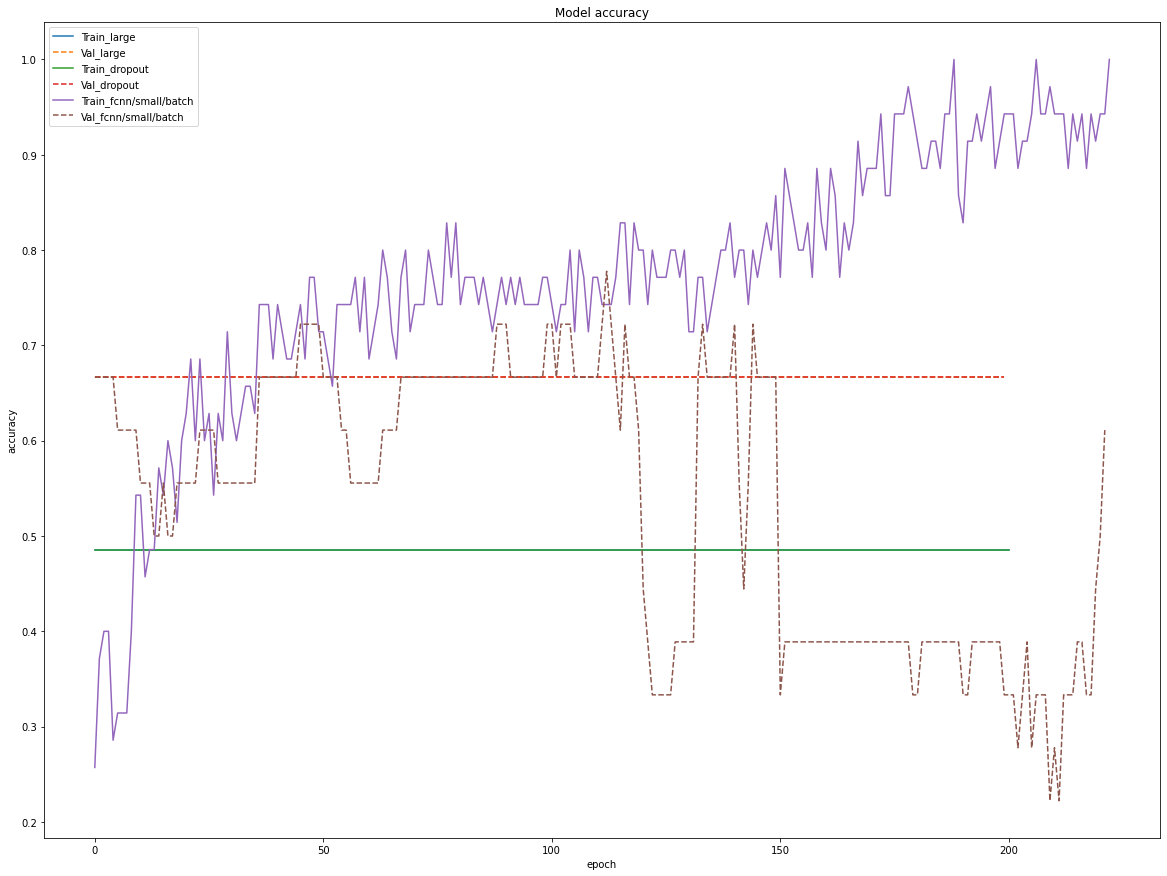

In [35]:
plot_report(batch_histories, 'accuracy')

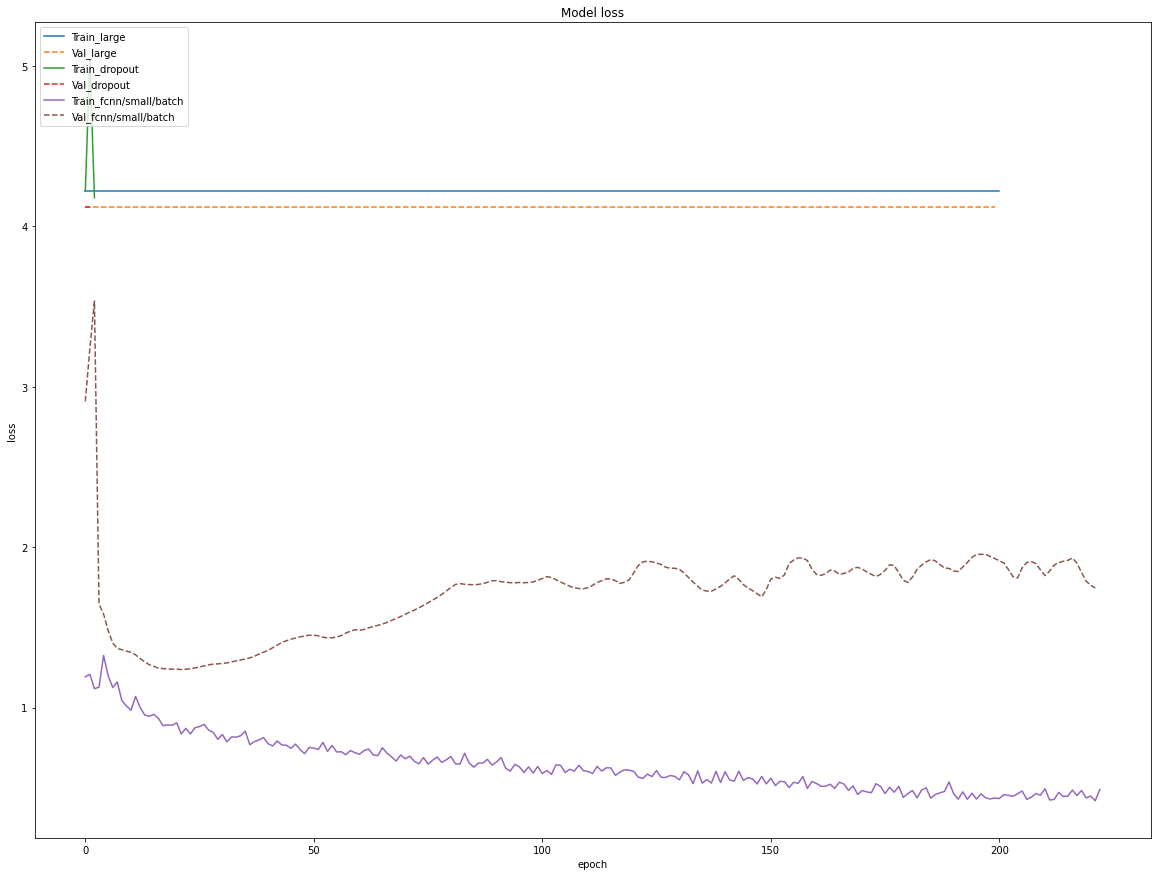

In [36]:
plot_report(batch_histories, 'loss')

## LSTM-FCNN

Univariate time series classification model, the Long Short Term Memory Fully Convolutional Network (LSTM-FCN) to capture time related information

In [37]:
lstm_histories = {}
lstm_histories['large'] = size_histories['fcnn/large']
lstm_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [38]:
lstm_units=24
lstm_tiny_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features,]),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)
                        ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
#     tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/tiny'] = compile_and_fit(lstm_tiny_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/tiny")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('test acc:', max(lstm_histories['lstm/tiny'].history["val_accuracy"]))
print('train acc:', max(lstm_histories['lstm/tiny'].history["accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 4096)           0         
                                                                 
 lstm (LSTM)                 (None, 24)                395616    
                                                                 
 batch_normalization (BatchN  (None, 24)               96        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 395,939
Trainable params: 395,891
Non-trainable params: 48
_________________________________________________

Epoch 51/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.1049 - accuracy: 0.4857 - val_loss: 1.1378 - val_accuracy: 0.1111
Epoch 52/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.1042 - accuracy: 0.4857 - val_loss: 1.1368 - val_accuracy: 0.1111
Epoch 53/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.1036 - accuracy: 0.4857 - val_loss: 1.1359 - val_accuracy: 0.1111
Epoch 54/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.1029 - accuracy: 0.4857 - val_loss: 1.1349 - val_accuracy: 0.1111
Epoch 55/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.1023 - accuracy: 0.4857 - val_loss: 1.0989 - val_accuracy: 0.6667
Epoch 56/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.1022 - accuracy: 0.4857 - val_loss: 1.0978 - val_accuracy: 0.6667
Epoch 57/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.1011 - accuracy: 0.4857 - val_loss: 1.0966 - val_accuracy: 0.6667
Epoch 58/100

Epoch 109/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.0790 - accuracy: 0.4857 - val_loss: 0.8861 - val_accuracy: 0.6667
Epoch 110/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.0787 - accuracy: 0.4857 - val_loss: 0.8860 - val_accuracy: 0.6667
Epoch 111/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.0784 - accuracy: 0.4857 - val_loss: 0.8860 - val_accuracy: 0.6667
Epoch 112/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.0781 - accuracy: 0.4857 - val_loss: 0.8860 - val_accuracy: 0.6667
Epoch 113/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.0779 - accuracy: 0.4857 - val_loss: 0.8860 - val_accuracy: 0.6667
Epoch 114/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.0776 - accuracy: 0.4857 - val_loss: 0.8860 - val_accuracy: 0.6667
Epoch 115/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.0774 - accuracy: 0.4857 - val_loss: 0.8861 - val_accuracy: 0.6667
Epoc

1/1 [==============================] - 0s 9ms/step - loss: 1.0696 - accuracy: 0.4857 - val_loss: 0.8986 - val_accuracy: 0.6667
Epoch 167/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.0695 - accuracy: 0.4857 - val_loss: 0.8989 - val_accuracy: 0.6667
Epoch 168/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.0694 - accuracy: 0.4857 - val_loss: 0.8993 - val_accuracy: 0.6667
Epoch 169/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.0694 - accuracy: 0.4857 - val_loss: 0.8996 - val_accuracy: 0.6667
Epoch 170/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.0693 - accuracy: 0.4857 - val_loss: 0.8999 - val_accuracy: 0.6667
Epoch 171/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.0692 - accuracy: 0.4857 - val_loss: 0.9002 - val_accuracy: 0.6667
Epoch 172/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.0691 - accuracy: 0.4857 - val_loss: 0.9348 - val_accuracy: 0.6667
Epoch 173/1000
1/1 [

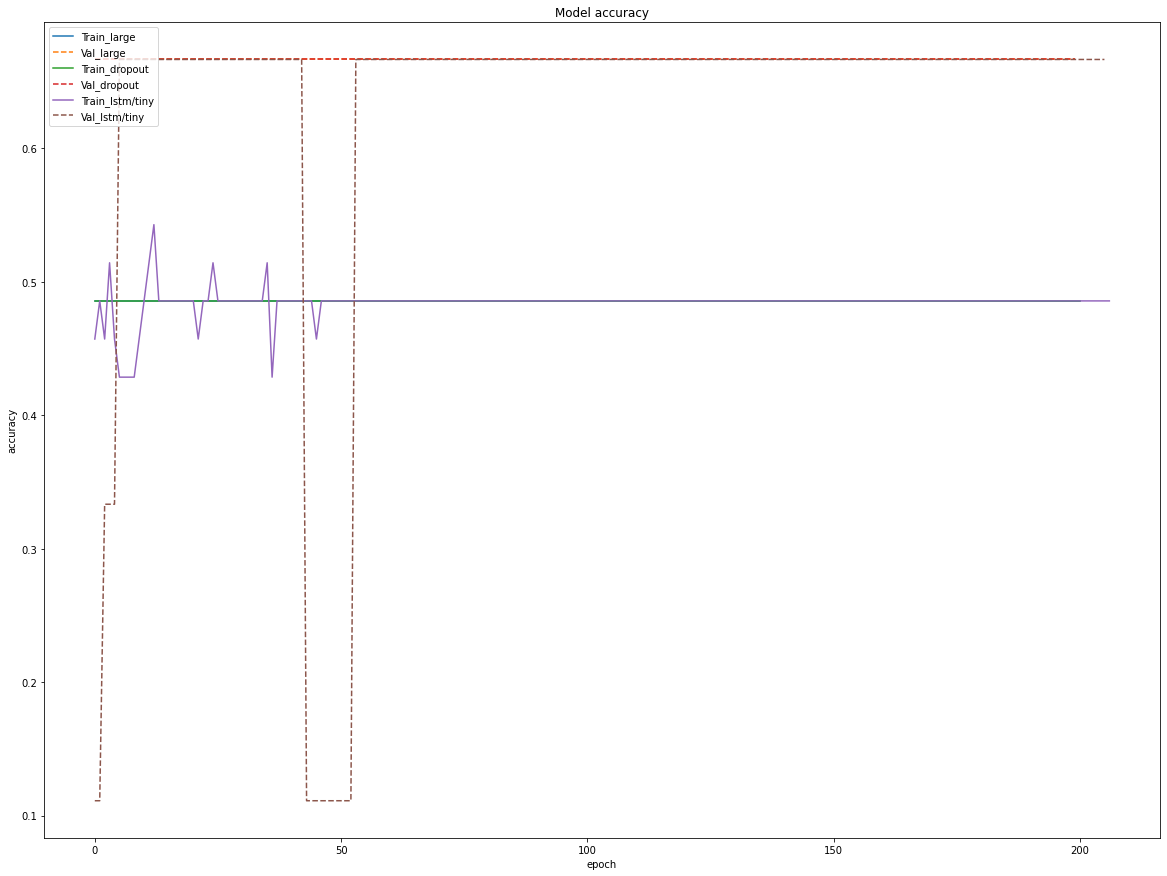

In [39]:
plot_report(lstm_histories, 'accuracy')

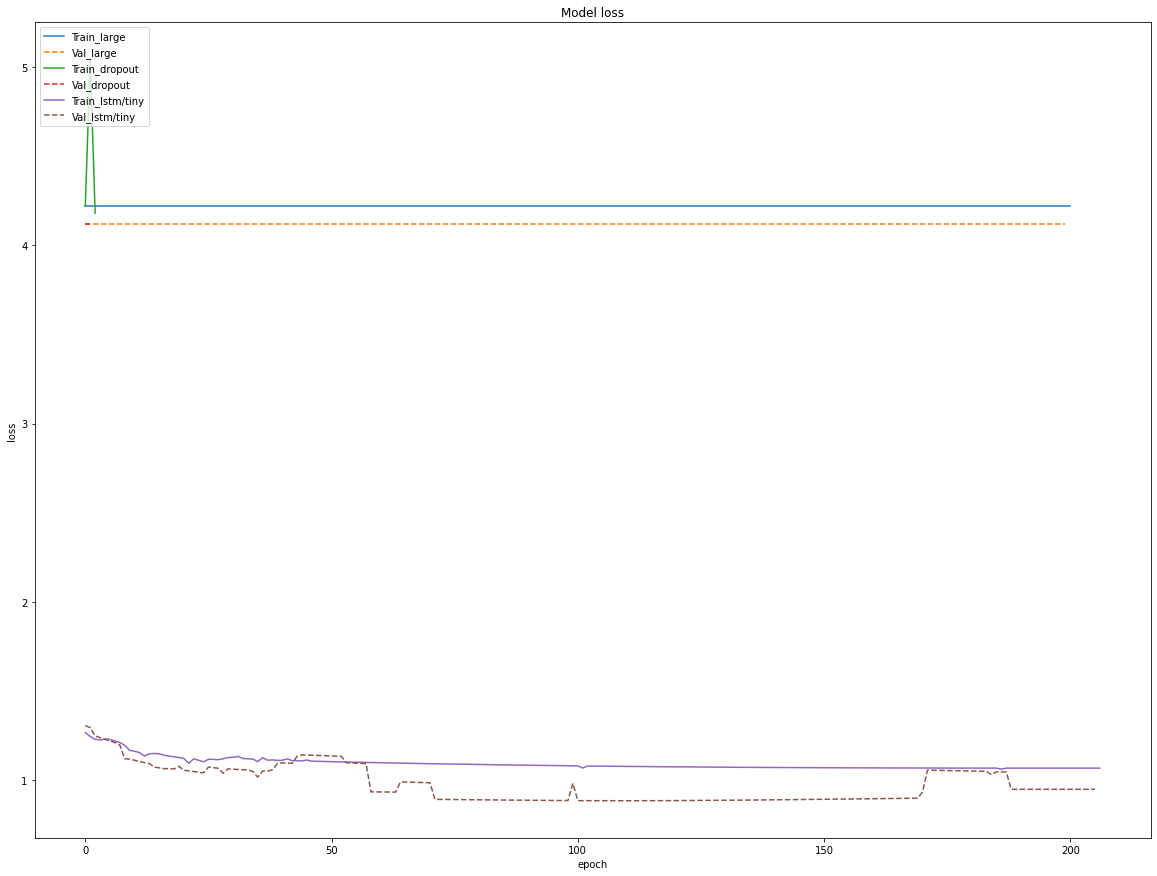

In [40]:
plot_report(lstm_histories, 'loss')

In [41]:
lstm_small_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features,]),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/small'] = compile_and_fit(lstm_small_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/small")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/small'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/small'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 4096)           0         
                                                                 
 lstm (LSTM)                 (None, 1, 24)             395616    
                                                                 
 batch_normalization (BatchN  (None, 1, 24)            96        
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 24)                4704      
                                                                 
 batch_normalization_1 (Batc  (None, 24)               96        
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 8)                 2

1/1 [==============================] - 0s 10ms/step - loss: 1.1467 - accuracy: 0.4857 - val_loss: 1.1182 - val_accuracy: 0.6667
Epoch 48/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.1453 - accuracy: 0.4857 - val_loss: 1.1165 - val_accuracy: 0.6667
Epoch 49/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.1449 - accuracy: 0.4857 - val_loss: 1.1150 - val_accuracy: 0.6667
Epoch 50/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.1460 - accuracy: 0.4857 - val_loss: 1.1134 - val_accuracy: 0.6667
Epoch 51/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.1398 - accuracy: 0.4857 - val_loss: 1.0806 - val_accuracy: 0.6667
Epoch 52/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.1396 - accuracy: 0.4857 - val_loss: 1.0789 - val_accuracy: 0.6667
Epoch 53/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.1409 - accuracy: 0.4857 - val_loss: 1.0757 - val_accuracy: 0.6667
Epoch 54/1000
1/1 [==

Epoch 105/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.1139 - accuracy: 0.4857 - val_loss: 0.9921 - val_accuracy: 0.6667
Epoch 106/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.1185 - accuracy: 0.4857 - val_loss: 0.9912 - val_accuracy: 0.6667
Epoch 107/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.1049 - accuracy: 0.4857 - val_loss: 0.9903 - val_accuracy: 0.6667
Epoch 108/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.1060 - accuracy: 0.4857 - val_loss: 0.9895 - val_accuracy: 0.6667
Epoch 109/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.1078 - accuracy: 0.4857 - val_loss: 0.9982 - val_accuracy: 0.6667
Epoch 110/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.1063 - accuracy: 0.4857 - val_loss: 0.9974 - val_accuracy: 0.6667
Epoch 111/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.1220 - accuracy: 0.4857 - val_loss: 0.9966 - val_accuracy: 0.6667

1/1 [==============================] - 0s 10ms/step - loss: 1.0755 - accuracy: 0.4857 - val_loss: 0.9900 - val_accuracy: 0.6667
Epoch 163/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.0958 - accuracy: 0.4857 - val_loss: 0.9895 - val_accuracy: 0.6667
Epoch 164/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.0824 - accuracy: 0.4857 - val_loss: 0.9891 - val_accuracy: 0.6667
Epoch 165/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.0998 - accuracy: 0.4857 - val_loss: 0.9713 - val_accuracy: 0.6667
Epoch 166/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.0729 - accuracy: 0.5143 - val_loss: 0.9885 - val_accuracy: 0.6667
Epoch 167/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.0962 - accuracy: 0.4857 - val_loss: 0.9882 - val_accuracy: 0.6667
Epoch 168/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.1042 - accuracy: 0.4857 - val_loss: 0.9879 - val_accuracy: 0.6667
Epoch 169/1000

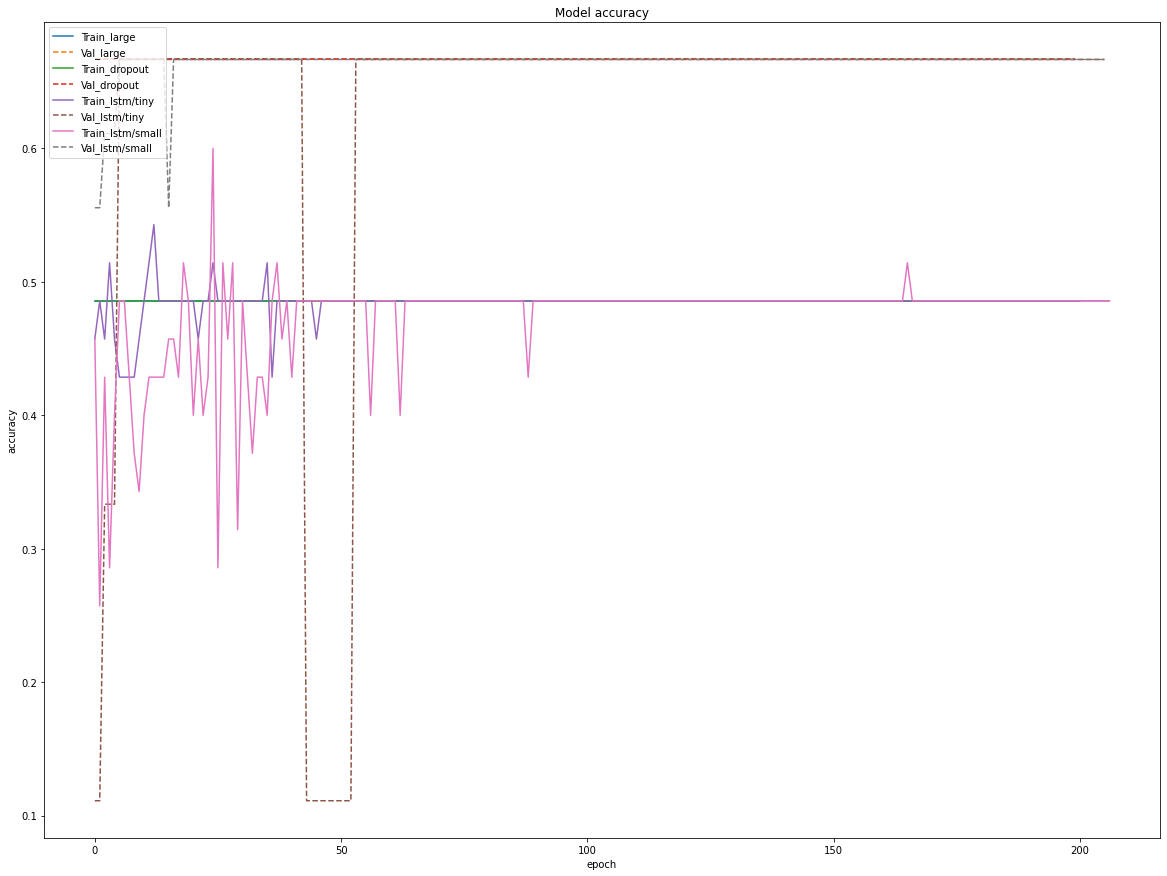

In [42]:
plot_report(lstm_histories, 'accuracy')

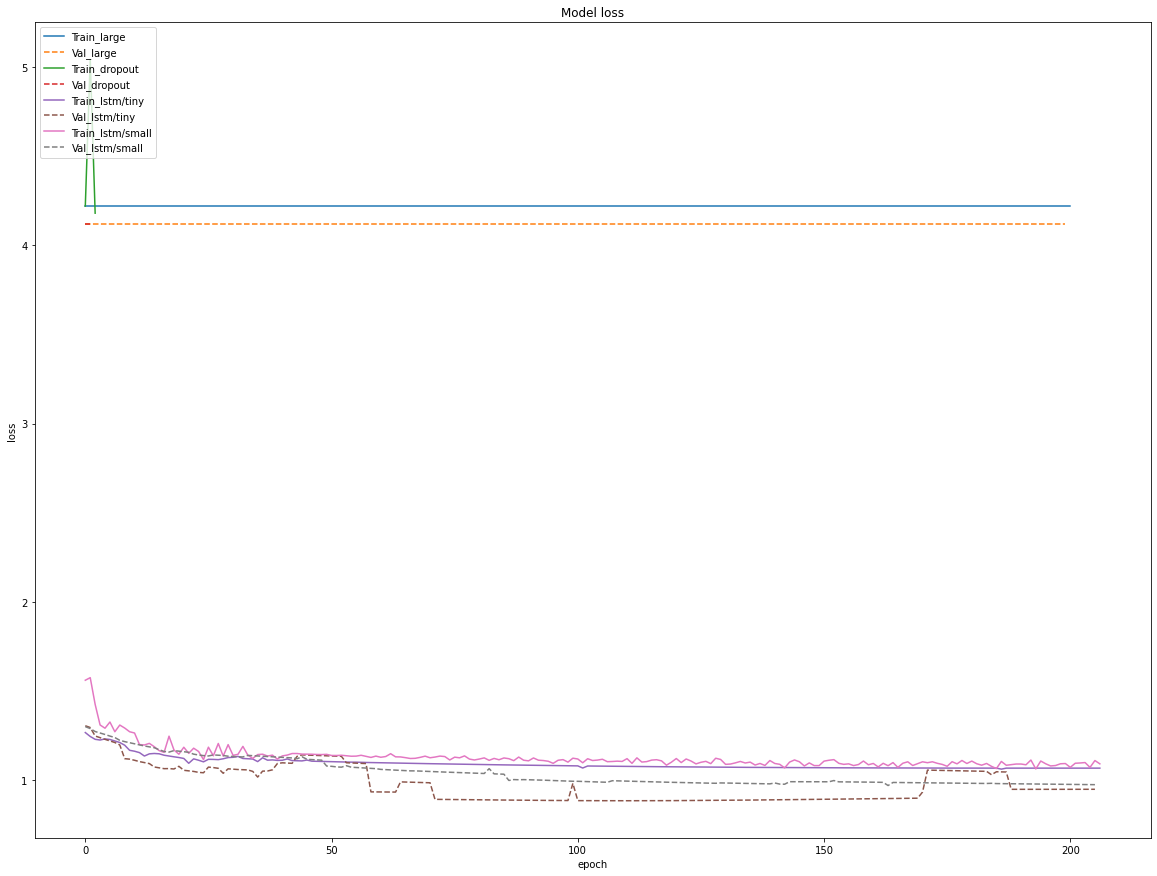

In [43]:
plot_report(lstm_histories, 'loss')

In [44]:
lstm_units=256
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_large_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features,]),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/large'] = compile_and_fit(lstm_large_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                lr=1e-4,
#                                                multiplier=10), 
                                                name="lstm/large")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/large'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 4096)           0         
                                                                 
 lstm (LSTM)                 (None, 1, 256)            4457472   
                                                                 
 batch_normalization (BatchN  (None, 1, 256)           1024      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 64)                1

1/1 [==============================] - 0s 15ms/step - loss: 1.8674 - accuracy: 0.4000 - val_loss: 1.6200 - val_accuracy: 0.6667
Epoch 40/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.6878 - accuracy: 0.4571 - val_loss: 1.6179 - val_accuracy: 0.6667
Epoch 41/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.6438 - accuracy: 0.2857 - val_loss: 1.6118 - val_accuracy: 0.6667
Epoch 42/1000
1/1 [==============================] - 0s 15ms/step - loss: 1.9349 - accuracy: 0.4000 - val_loss: 1.6053 - val_accuracy: 0.6667
Epoch 43/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.9376 - accuracy: 0.2286 - val_loss: 1.6020 - val_accuracy: 0.6667
Epoch 44/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.6419 - accuracy: 0.3714 - val_loss: 1.5989 - val_accuracy: 0.6667
Epoch 45/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.7750 - accuracy: 0.4000 - val_loss: 1.5924 - val_accuracy: 0.6667
Epoch 46/1000
1/1 [=

Epoch 97/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.5497 - accuracy: 0.4571 - val_loss: 1.5003 - val_accuracy: 0.6667
Epoch 98/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.5628 - accuracy: 0.4857 - val_loss: 1.5015 - val_accuracy: 0.6667
Epoch 99/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.5552 - accuracy: 0.4857 - val_loss: 1.4973 - val_accuracy: 0.6667
Epoch 100/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.5761 - accuracy: 0.4286 - val_loss: 1.4949 - val_accuracy: 0.6667
Epoch 101/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.6241 - accuracy: 0.4571 - val_loss: 1.4923 - val_accuracy: 0.6667
Epoch 102/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.6220 - accuracy: 0.4571 - val_loss: 1.4978 - val_accuracy: 0.6667
Epoch 103/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.5588 - accuracy: 0.4286 - val_loss: 1.4956 - val_accuracy: 0.6667
Ep

1/1 [==============================] - 0s 13ms/step - loss: 1.5036 - accuracy: 0.4857 - val_loss: 1.4051 - val_accuracy: 0.6667
Epoch 155/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.5161 - accuracy: 0.4857 - val_loss: 1.4038 - val_accuracy: 0.6667
Epoch 156/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.4926 - accuracy: 0.4857 - val_loss: 1.4026 - val_accuracy: 0.6667
Epoch 157/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.5275 - accuracy: 0.4571 - val_loss: 1.4013 - val_accuracy: 0.6667
Epoch 158/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.4922 - accuracy: 0.4857 - val_loss: 1.4000 - val_accuracy: 0.6667
Epoch 159/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.5429 - accuracy: 0.4571 - val_loss: 1.3987 - val_accuracy: 0.6667
Epoch 160/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.4922 - accuracy: 0.4857 - val_loss: 1.3974 - val_accuracy: 0.6667
Epoch 161/1000

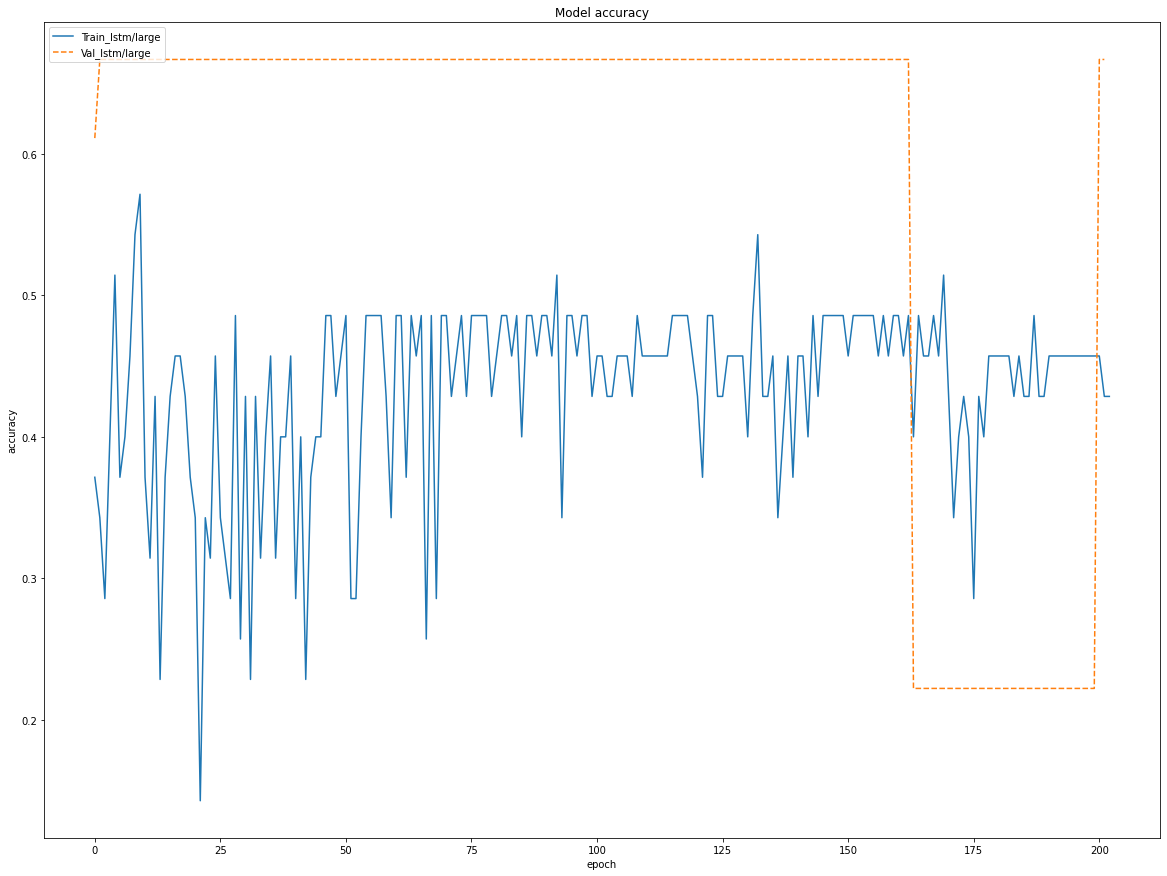

In [45]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'accuracy')

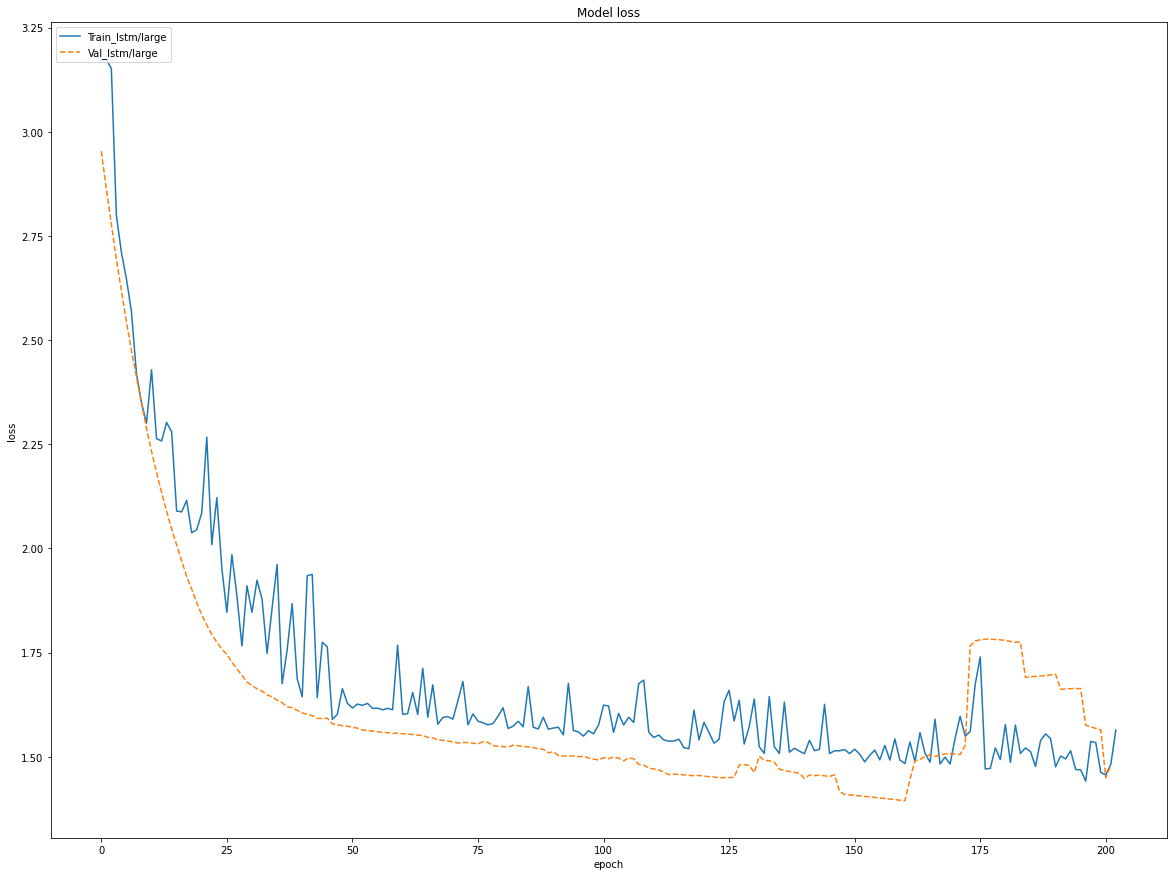

In [46]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'loss')